In [1]:
%matplotlib inline

In [2]:
import numpy as np
from matplotlib import pyplot, cm

inf = np.inf
isclose = np.isclose
π = np.pi
arctan = np.arctan
sign = np.sign

In [125]:
class Controller(object):
    '''Single Axis PID Controller'''
    def __init__(self,set_point=0,limits=(-inf,inf),kp=1,ki=0,kd=0,t0=0):
        # set point and control constants
        self.set_point = set_point
        self.cmin,self.cmax = limits
        self.kp = kp
        self.ki = ki
        self.kd = kd

        # time of previous call, running integral and
        # proportional term of previous call
        self.t0 = t0
        self.kiI  = 0
        self.P0 = 0

        # response value of previous call
        self.c = 0

    def __call__(self,x,t):
        # return previous value if no time has passed
        if isclose(t - self.t0, 0):
            return self.c

        # bring instance variables into local scope
        xset = self.set_point
        cmin = self.cmin
        cmax = self.cmax
        kp = self.kp
        ki = self.ki
        kd = self.kd

        # if parameters are all zero or None, return set point
        if not any([kp,ki,kd]):
            self.t0 = t
            return xset

        # bring instance variables into local scope
        t0 = self.t0
        kiI  = self.kiI
        P0 = self.P0

        # calculate PID terms
        Δt = t - t0
        P = xset - x
        ΔP = P - P0
        D = ΔP / Δt

        if self.ki > 0:
            if not (cmin < kp*P < cmax):
                kiI = 0
            else:
                kiI += ki * P * Δt
            kiI = min(max(kiI,cmin),cmax)

        c = kp*P + kiI + kd*D

        # clip output to specified limits
        c = min(max(c,cmin),cmax)

        # save parameters to class instance
        self.t0 = t
        self.kiI = kiI
        self.P0 = P
        self.c  = c

        return c

    @property
    def ti(self):
        '''integral time'''
        return self.kp / self.ki
    @ti.setter
    def ti(self,ti):
        self.ki = self.kp / ti

    @property
    def td(self):
        '''derivative time'''
        return self.kd / self.kp
    @td.setter
    def td(self,td):
        self.kd = self.kp * td

    @property
    def ku(self):
        '''ultimate gain, assuming classic ziegler-nichols pid scheme'''
        return (1/.6)*self.kp
    @ku.setter
    def ku(self,ku):
        self.kp = .6*ku

    @property
    def tu(self):
        '''period of oscillation at ultimate gain'''
        return 2*self.kp/self.ki
    @tu.setter
    def tu(self,tu):
        self.ki = 2*self.kp/tu
        self.kd = self.kp*tu/8

    def ziegler_nichols(self,ku,tu,control_type='pid'):
        '''
            ku = ultimate gain
            tu = period of oscillation at ultimate gain
        '''
        converter = dict(
            p = lambda ku,tu: (.5*ku, 0, 0),
            pi = lambda ku,tu: (.45*ku, 1.2*(.45*ku)/tu, 0),
            pd = lambda ku,tu: (.8*ku, 0, (.8*ku)*tu/8),
            pid = lambda ku,tu: (.6*ku, 2*(.6*ku)/tu, (.6*ku)*tu/8),
            pessen = lambda ku,tu: (.7*ku, 2.5*(.7*ku)/tu, 3*(.7*ku)*tu/20),
            some_overshoot = lambda ku,tu: (.33*ku, 2*(.33*ku)/tu, (.33*ku)*tu/3),
            no_overshoot = lambda ku,tu: (.2*ku, 2*(.2*ku)/tu, (.2*ku)*tu/3)
        )
        self.kp,self.ki,self.kd = converter[control_type.lower()](ku,tu)

In [126]:
con = Controller(set_point=0,limits=(-inf,inf),kp=1,ki=0.6,kd=1,t0=0)
con.ti

1.6666666666666667

In [155]:
class Device(object):
    def __init__(self):
        # position, velocity, acceleration
        self.x = 0
        self.v = 0
        
        # mass, drag, spring-constant, spring equilibrium point
        self.m = 1    # mass, inertial, moment of inertia
        self.b = 0    # drag
        self.k = 0    # spring
        self.x0 = 0   # equilibrium point
        
        # gain (maximum control), sensitivity
        self.g = 1
        self.s = 1
        
    def control_force(self,c):
        '''represents physical limitation of the control'''
        
        # bring instance variables into local scope
        g = self.g
        s = self.s
        
        def _control_force(g,s):
            if s == 0:
                def _fn(c):
                    return g * c
            elif s > 0:
                def _fn(c):
                    return g * arctan(s*c) / arctan(s)
            else:
                def _fn(c):
                    return sign(c) * g * (1 - arctan(s*(1-abs(c))) / arctan(s))
            return _fn

        return _control_force(g,s)(c)
        
    def force(self,c):
        '''control force plus the external forces (drag, etc)'''
        
        # bring instance variables into local scope
        x = self.x
        v = self.v
        b = self.b
        k = self.k
        x0 = self.x0
        
        Fcontrol = self.control_force(c)
        Fdrag = int(v<0) * b * v**2
        Fspring = -k * (x - x0)
        
        return Fcontrol + Fdrag + Fspring
        
    def __call__(self,c,Δt):
        '''set the control to c for Δt time
        
        return the position and velocity after Δt has passed
        
        This device has a characteristic "mass" which gives
        it a certain momentum that the control must fight against
            
            ΣF = Δp / Δt
            ΣF = m * Δv / Δt
            v = v + (ΣF/m)*Δt
            x = x + v*Δt
        '''
        # bring instance variables into local scope
        x = self.x
        v = self.v
        m = self.m
        
        # sum of forces
        ΣF = self.force(c)
        
        # change in velocity and position
        x = x + v*Δt
        v = v + (ΣF/m)*Δt
        
        # save parameters to class instance
        self.x = x
        self.v = v
        
        return x,v

In [156]:
def simulate(xset,
             kp,ki,kd,
             m,b,k,x0,
             g=1,s=0,
             total_time=10,npoints=100):

    dev = Device()
    dev.m = m
    dev.b = b
    dev.k = k
    dev.x0 = x0
    dev.g = g
    dev.s = s
    
    cont = Controller()
    cont.kp = kp
    cont.ki = ki
    cont.kd = kd
    cont.cmin = -1
    cont.cmax = 1
    
    tt = np.linspace(-1,2*total_time, npoints)
    
    xx0 = np.zeros(tt.shape)
    xx0[tt>0] = xset
    xx0[tt>total_time] = 0
    
    xx = [0]
    vv = [0]
    aa = [0]
    
    t0 = tt[0]
    flip = False
    for t,x0 in zip(tt[1:],xx0[1:]):
        cont.set_point = x0
        a = cont(dev.x,t)
        x,v = dev(a,t-t0)
        aa.append(a)
        xx.append(x)
        vv.append(v)
        t0 = t
        
    return tt, xx0, aa, xx, vv

def plot_simulation(tt,xx0,aa,xx,vv):
    fig,ax = pyplot.subplots(1,1,figsize=(12,3))
    axr = ax.twinx()
    
    ptset, = ax.plot(tt, xx0, color='blue', alpha=0.6, lw=2)
    ptval, = ax.plot(tt, xx, color='green', alpha=0.6, lw=2)
    
    ptcont, = axr.plot(tt, aa, color='red', alpha=0.6, lw=2)
    ptvel,  = axr.plot(tt, vv, color='magenta', alpha=0.6, lw=2)
    
    ax.set_xlim(-1,None)
    axr.set_ylim(-1.05,1.05)
  
    l = ax.legend((ptset,ptcont,ptval,ptvel), ('set point','control','actual','velocity'),
              loc='best')
    l.set_zorder(1)
    

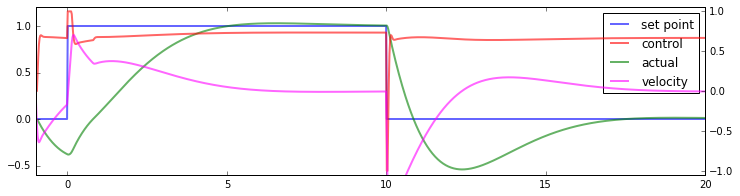

In [207]:
_=plot_simulation(*simulate(xset=1,
                  kp=1, ki=0.5, kd=1,
                  m=1, b=1, k=1, x0=-10,
                  g=15, s=0,
                  total_time=10, npoints=1000))

xset: 0.17453292519943295


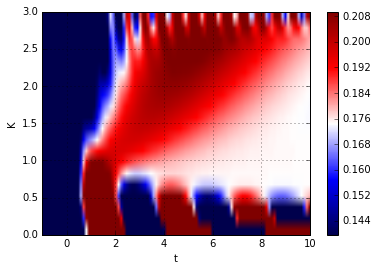

In [173]:
kk = np.linspace(0,3,20)
data = np.empty((20,100))
for i,k in enumerate(kk):
    data[i][:] = simulate(xset=10*π/180,
                kp=1.3, ki=0.5, kd=k,
                m=1733, b=0, k=1000, x0=0,
                g=5000, s=0,
                total_time=10, npoints=100)[3]

fig,ax = pyplot.subplots()
im = ax.imshow(data,
          origin='lower', aspect='auto',
          vmin=xset-0.2*xset, vmax=xset+0.2*xset,
          extent=[-1,10,kk.min(),kk.max()],
          cmap=cm.seismic)
_=ax.set_xlabel('t')
_=ax.set_ylabel('K')
_=ax.grid(True)
cb=pyplot.colorbar(im)
print('xset:',xset)

/usr/lib/python3.4/site-packages/ipykernel/__main__.py:19: RuntimeWarning: overflow encountered in double_scalars


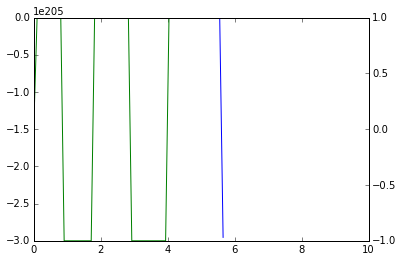

In [5]:
moi = 1733 # kg m^2
torque = 5000 # kg m^2 / s^2

# We want to be able to rotate at about 3 deg / s
# so 30 deg in 10 seconds
npoints = 100
tt = np.linspace(0,10,npoints)
xx = np.empty((npoints,))
vv = np.empty((npoints,))
cc = np.empty((npoints,))

dev = LinearDevice(t=0, x=-15, v=0, inertia=1733, drag=1, max_force=5000)
con = Controller(set_point=0, kp=1, ki=0.6, kd=1, t0=0)
con.min = -1
con.max = 1
for j,t in enumerate(tt):
    c = con(dev.x,t)
    x = dev(c,t)
    cc[j] = c
    xx[j] = x
    vv[j] = dev.v

fig,ax = pyplot.subplots()
_=ax.plot(tt,xx, color='blue')
axr = ax.twinx()
_=axr.plot(tt,cc, color='green')

In [184]:
print(xx[-22:-18])
print(cc[-22:-18])
print(vv[-22:-18])

[  3.25994504e+04   1.08330393e+07   1.36327712e+12   2.17164011e+22]
[-1. -1. -1. -1.]
[  1.35347284e+06   1.68704203e+11   2.65422680e+21   6.65207778e+41]


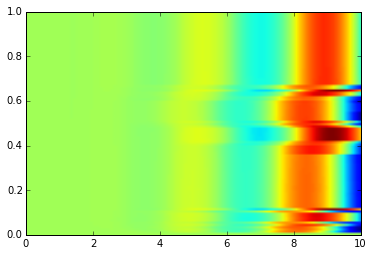

In [32]:
moi = 1733 # kg m^2
torque = 5000 # kg m^2 / s^2


kkp = np.linspace(0,1,100)
tt = np.linspace(0,10,100)
xx = np.empty((100,100))
cc = np.empty((100,100))

for i,kp in enumerate(kkp):
    dev = LinearDevice(t=0, x=10, v=0, inertia=1733, max_force=5000)
    con = Controller(set_point=0, kp=kp, kd=0, ki=0, t0=0)
    for j,t in enumerate(tt):
        c = con(dev.x,t)
        x = dev(c,t)
        cc[i,j] = c
        xx[i,j] = x

pyplot.imshow(xx, extent=[0,10,0,1],origin='lower',aspect='auto')

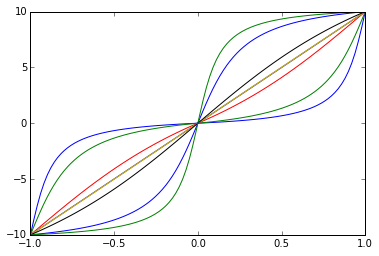

In [102]:
from numpy import tan, arctan, sign
from numpy import pi as π

def control_force(g,s):
    if s == 0:
        def _fn(c):
            return g * c
    elif s > 0:
        def _fn(c):
            return g * arctan(s*c) / arctan(s)
    else:
        def _fn(c):
            return sign(c) * g * (1 - arctan(s*(1-abs(c))) / arctan(s))
    return _fn

cc = np.linspace(-1,1,100)

fig,ax = pyplot.subplots()
for s in [-10,-5,-1,-0.1,0,.1,1,5,10]:
    ax.plot(cc, control_force(10,s)(cc))

In [31]:
arctan(1) == π/4

True

In [30]:
tan(2/π)

0.7393029504866041